<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA/blob/master/Assignment%2011/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Here we are finding best starting LR by LR_finder.

* For finding LR, we see the loss vs LR graph and select a point where the loss function is descending fastest.
* Here we found out Loss was descending more steeply in the range of .00003 to .003 almost equally. So we took the almost maximum of this range, i.e. .002 as our starting best LR
* One observation - while finding the best LR, I kept batch size as 128, beacuse I will be using batch size as 128 in later training. I believe that LR is related to batch size, so found best for the same.
* Another observation - while finding best LR, the model didn't ran even for 1 epoch. That means the loss starts diverging and the code is stopped.
*  #### Rohan, Please validate on the above 2 points.

### Observations - 

* #### While using a constant bigger LR(0.01), we come closer to optimum point in early epochs(around epoch = 10), but then the accuracy will fluctuate there.
* #### While using LR too small(0.0009), both training and validation accuracy will move forward slowly and wont be able to rach the optimum point. FOr me after 100 epochs, both were able to reach only till 78-79%
* #### After using the LR from LR finder the validation accuracy moved on a descent pace and was able to reach 87.41%


In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import SGD
import os
import math

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


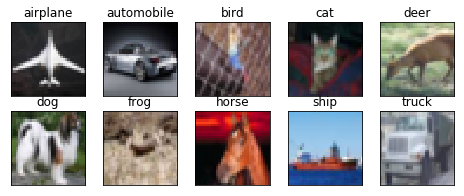

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [6]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
## image normalization

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(train_features)
# print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))
iterator = datagen.flow(train_features, train_labels, batch_size=len(train_features), shuffle=False)
train_features, train_labels = iterator.next()

iterator_test = datagen.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features, test_labels = iterator_test.next()

print(train_features.shape, train_features.mean(), train_features.std())
print(test_features.shape, test_features.mean(), test_features.std())


# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

(50000, 32, 32, 3) -2.1983838e-06 0.9999975
(10000, 32, 32, 3) 0.012807535 0.9986801


#### WE start with defining a model and running it to find best starting LR.
#### Here we used SGD with LR = 0.01, we can replace this LR with the best we will find.

In [7]:
# Model before LR finder
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

# Compile the model
# model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.compile(optimizer=SGD(lr=.01, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

W0806 09:39:38.375122 140321844492160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0806 09:39:38.392677 140321844492160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 09:39:38.395794 140321844492160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 09:39:38.435328 140321844492160 deprecation_wrapper.py

In [8]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

#### Below we defined the LR class, and used it further to find the best LR.
#### For finding LR, we see the loss vs LR graph and select a point where the loss function is descending fastest.
#### Here we found out Lloss was descending more steeply in the range of .00003 to .003 almost equally. So we took the almost maximum of this range, i.e. .002 as our starting best LR 
#### One observation - while finding the best LR, I kept batch size as 128, beacuse I will be using batch size as 128 in later training. I believe that LR is related to batch size, so found best for the same.
#### Another observation - while finding best LR, the model didn't ran even for 1 epoch. That means the loss starts diverging and the code is stopped.
### Rohan, Please validate the last 2 points.

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])



In [10]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))
model1.fit(train_features, train_labels, callbacks=[lr_finder] )

W0806 09:39:41.068737 140321844492160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
11744/50000 [======>.......................] - ETA: 44s - loss: 3.6325 - acc: 0.2068

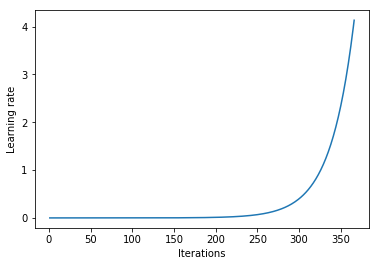

In [11]:
lr_finder.plot_lr()


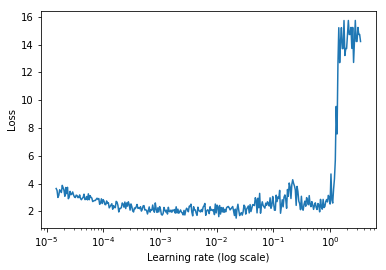

In [12]:
lr_finder.plot()

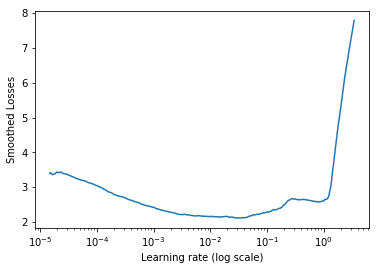

In [13]:
lr_finder.plot_smoothed_loss()

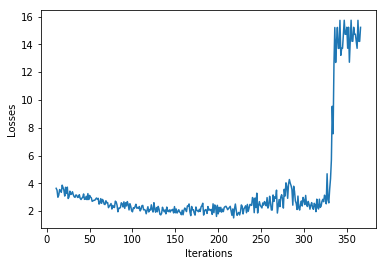

In [14]:
lr_finder.plot_loss()

#### Here I have defined cutout, and used it further to train the model with the newly found best starting LR = 0.002

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser
 

In [8]:
# Model with LR and cutout
model_LR_cutout = Sequential()
model_LR_cutout.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model_LR_cutout.add(Activation('relu'))
model_LR_cutout.add(BatchNormalization())

model_LR_cutout.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model_LR_cutout.add(Activation('relu'))
model_LR_cutout.add(BatchNormalization())

model_LR_cutout.add(MaxPooling2D(pool_size=(2, 2)))
model_LR_cutout.add(Dropout(0.2))

model_LR_cutout.add(Convolution2D(32, 1, 1))


model_LR_cutout.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model_LR_cutout.add(Activation('relu'))
model_LR_cutout.add(BatchNormalization())

model_LR_cutout.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model_LR_cutout.add(Activation('relu'))
model_LR_cutout.add(BatchNormalization())

model_LR_cutout.add(MaxPooling2D(pool_size=(2, 2)))
model_LR_cutout.add(Dropout(0.3))

model_LR_cutout.add(Convolution2D(32, 1, 1))


model_LR_cutout.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model_LR_cutout.add(Activation('relu'))
model_LR_cutout.add(BatchNormalization())

model_LR_cutout.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model_LR_cutout.add(Activation('relu'))
model_LR_cutout.add(BatchNormalization())

model_LR_cutout.add(MaxPooling2D(pool_size=(2, 2)))
model_LR_cutout.add(Dropout(0.5))

model_LR_cutout.add(Convolution2D(10, 1, 1))

model_LR_cutout.add(AveragePooling2D(pool_size = (4,4)))
model_LR_cutout.add(Flatten())


model_LR_cutout.add(Activation('softmax'))

# Compile the model
# model_LR_cutout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model_LR_cutout.compile(optimizer=SGD(lr=.01, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])


sgd = SGD(lr=0.002, decay=0, momentum=0.9, nesterov=True)
model_LR_cutout.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0806 10:01:22.395878 139793181976448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0806 10:01:22.416208 139793181976448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 10:01:22.419687 139793181976448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 10:01:22.459375 139793181976448 deprecation_wrapper.py

In [9]:
model_LR_cutout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if __name__ == '__main__':
W0806 10:01:27.462157 139793181976448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated

Epoch 1/100
390/390 [==============================] - 30s 76ms/step - loss: 1.6614 - acc: 0.4129 - val_loss: 1.3567 - val_acc: 0.5293
Epoch 2/100
390/390 [==============================] - 28s 71ms/step - loss: 1.3265 - acc: 0.5383 - val_loss: 1.1333 - val_acc: 0.6121
Epoch 3/100
390/390 [==============================] - 28s 71ms/step - loss: 1.1910 - acc: 0.5869 - val_loss: 1.0670 - val_acc: 0.6343
Epoch 4/100
390/390 [==============================] - 27s 70ms/step - loss: 1.1070 - acc: 0.6207 - val_loss: 1.0247 - val_acc: 0.6493
Epoch 5/100
390/390 [==============================] - 27s 70ms/step - loss: 1.0434 - acc: 0.6438 - val_loss: 0.9450 - val_acc: 0.6811
Epoch 6/100
390/390 [==============================] - 27s 70ms/step - loss: 0.9957 - acc: 0.6610 - val_loss: 0.9058 - val_acc: 0.6917
Epoch 7/100
390/390 [==============================] - 27s 70ms/step - loss: 0.9479 - acc: 0.6767 - val_loss: 0.8652 - val_acc: 0.7088
Epoch 8/100
390/390 [==============================] - 

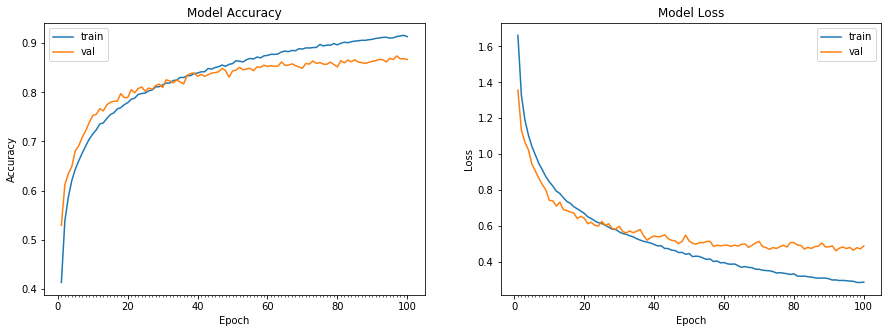

Accuracy on test data is: 86.69


In [10]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=get_random_eraser(v_l=0, v_h=1))

# datagen.fit(train_features)

start = time.time()
model_LR_cutout_info = model_LR_cutout.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_LR_cutout_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model_LR_cutout))

## Printing - highest validation accuracy below

In [14]:
max(model_LR_cutout_info.history['val_acc'])

0.8741

### GradCAM results on the 25 misclassified images

W0806 16:23:13.719639 139793181976448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0806 16:23:13.744760 139793181976448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0806 16:23:14.896425 139793181976448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0806 16:23:14.918889 139793181976448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0806 16:23:16.246857 139793181976448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0806 16:23:16.270845 139793181976448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0806 16:23:17.456598 139793

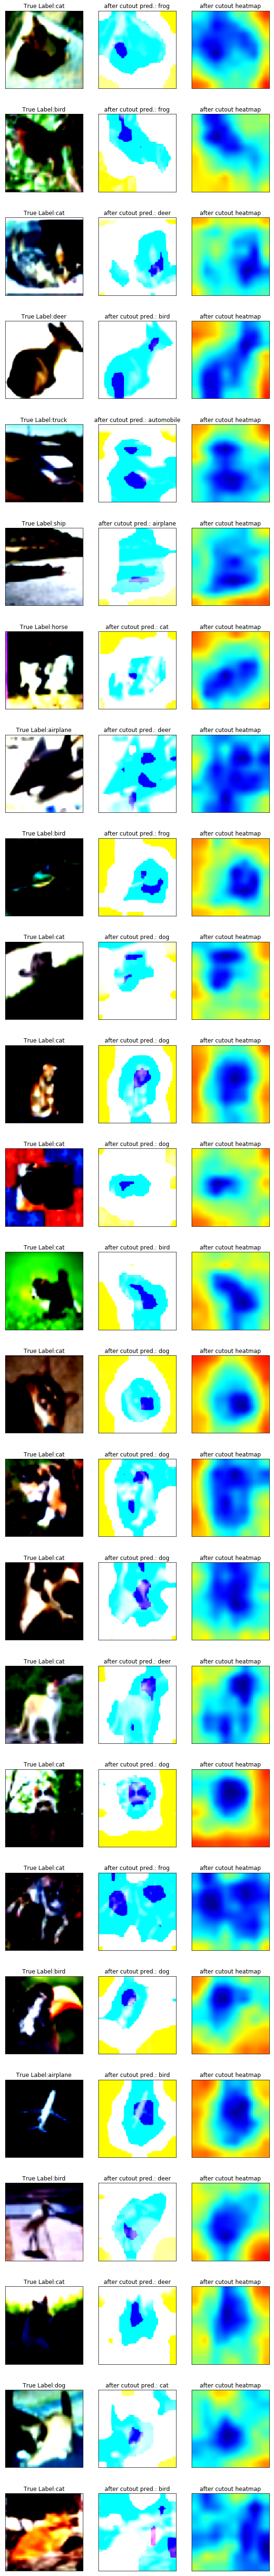

In [38]:
import random
import cv2
from keras.preprocessing import image

Y_pred_after = model_LR_cutout.predict(test_features)
Y_pred_classes_after = np.argmax(Y_pred_after, axis = 1)
Y_true = np.argmax(test_labels, axis = 1)
error_after = (Y_pred_classes_after - Y_true != 0)
reqd = [error_after[i] for i in range(len(error_after))]
reqd = [i for i, x in enumerate(reqd) if x]
index_list = random.sample(reqd, 25)
# index_list = [4926,4732,8301,3068, 4545]
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(10,100))
for ii in range(len(index_list)):
  img = test_features[index_list[ii]]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds_after = model_LR_cutout.predict(x)
  class_idx_after = np.argmax(preds_after[0])
  Y_true = np.argmax(test_labels[index_list[ii]]) 
  class_output_after = model_LR_cutout.output[:, class_idx_after]
  last_conv_layer_after = model_LR_cutout.get_layer("activation_5")
  grads_after = K.gradients(class_output_after, last_conv_layer_after.output)[0]
  pooled_grads_after = K.mean(grads_after, axis=(0, 1, 2))
  iterate_after = K.function([model_LR_cutout.input], [pooled_grads_after, last_conv_layer_after.output[0]])
  pooled_grads_value_after, conv_layer_output_value_after = iterate_after([x])
  for i in range(8):
    conv_layer_output_value_after[:, :, i] *= pooled_grads_value_after[i]
    
  heatmap_after = np.mean(conv_layer_output_value_after, axis=-1)
  heatmap_after = np.maximum(heatmap_after, 0)
  heatmap_after /= np.max(heatmap_after)
#   print(heatmap_after.shape)
  heatmap_after = cv2.resize(heatmap_after, (img.shape[1], img.shape[0]))
  heatmap_after = np.uint8(255 * heatmap_after)
  heatmap_after = cv2.applyColorMap(heatmap_after, cv2.COLORMAP_JET)
  superimposed_img_after = cv2.addWeighted(img, 0.6, heatmap_after, 0.4, 0, dtype = cv2.CV_32F)

  ax = fig.add_subplot(25,3, 1 + 3*ii, xticks=[], yticks=[])
  ax.set_title("True Label:{}".format(class_names[Y_true]))
  plt.imshow(cv2.resize(img, (128, 128)))
  
  ax = fig.add_subplot(25,3, 2 + 3*ii, xticks=[], yticks=[])
  ax.set_title("after cutout pred.: {}".format(class_names[class_idx_after]))
  plt.imshow(cv2.resize(superimposed_img_after, (128, 128)))
  
  ax = fig.add_subplot(25,3, 3 + 3*ii, xticks=[], yticks=[])
  ax.set_title("after cutout heatmap")
  plt.imshow(cv2.resize(heatmap_after, (128, 128)))
  
  cv2.waitKey(0)
# plt.show()